In [1]:
import os
import time
import copy
import numpy as n
import numpy.lib.recfunctions as rfn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import umap
import matplotlib
from sklearn.decomposition import PCA

In [119]:
import pickle

In [69]:
from sklearn import svm

In [58]:
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 12

In [2]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data
def extract_data(trial):
    num_markers = int((len(trial.dtype.names)-2)/2)

    all_labels = trial.dtype.names[2:]

    markers_1 = []
    markers_2 = []
    positions_1 = n.zeros((trial.shape[0], int(num_markers/2), 2))
    positions_2 = n.zeros((trial.shape[0], int(num_markers/2), 2))

    for i in range(num_markers):
        label = all_labels[i*2][:-2]
        label_x = label+'_x'
        label_y = label+'_y'
        if label[-1] == '1':
            markers_1.append(label)
            idx = len(markers_1)-1
            positions_1[:,idx, 0] = trial[label_x]
            positions_1[:,idx, 1] = trial[label_y]
        else:
            markers_2.append(label)
            idx = len(markers_2)-1
            positions_2[:,idx,0] = trial[label_x]
            positions_2[:,idx,1] = trial[label_y]
    return n.array(markers_1), n.array(markers_2), positions_1, positions_2

In [47]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / n.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (n.arccos(n.clip(n.dot(v1_u, v2_u), -1.0, 1.0)))

def convert_to_ego(mark_1, mark_2, pos_1, pos_2, anchor_label='GreenTape_1', anchor_2_label='RedTape_1'):
    anchor_idx = n.where(mark_1==anchor_label)[0][0]
    anchor_2_idx =  n.where(mark_1==anchor_2_label)[0][0]
    pos_1_ego = pos_1.copy()
    pos_2_ego = pos_2.copy()

    pos_1_ego = pos_1_ego - n.stack([[pos_1[:,anchor_idx]]]*pos_1.shape[1], axis=2)[0]
    pos_2_ego = pos_2_ego - n.stack([[pos_1[:,anchor_idx]]]*pos_1.shape[1], axis=2)[0]

    for t in range(pos_1_ego.shape[0]):
        anchor_vector = pos_1_ego[t,anchor_2_idx].copy()
        angle = -angle_between(anchor_vector, n.array((1,0)))
        if n.all(anchor_vector[1] < 0): angle *= -1
        for i in range(pos_1_ego.shape[1]):
            vector_1 = pos_1_ego[t,i]
            x_1 = n.cos(angle) * vector_1[0] - n.sin(angle) * vector_1[1]
            y_1 = n.sin(angle) * vector_1[0] + n.cos(angle) * vector_1[1]
            pos_1_ego[t,i] = [x_1, y_1]

            vector_2 = pos_2_ego[t,i]
            x_2 = n.cos(angle) * vector_2[0] - n.sin(angle) * vector_2[1]
            y_2 = n.sin(angle) * vector_2[0] + n.cos(angle) * vector_2[1]
            pos_2_ego[t,i] = [x_2, y_2]
    return pos_1_ego, pos_2_ego

In [3]:
# LOAD RAW DATA
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'
dlc_path = os.path.join(data_root, dlc_dir)
ann_path = os.path.join(data_root, ann_dir)

all_data = load_data(data_root, dlc_dir, ann_dir)

In [48]:
# PROCESS RAW DATA
# 45: since the first n_window/2 frames lack latents in the VAME output
trial = all_data['Female1'][11045:25000]
mark_1, mark_2, pos_1, pos_2 = extract_data(trial)
pos_1_ego, pos_2_ego = convert_to_ego(mark_1, mark_2, pos_1, pos_2)
unique_labels = n.unique(trial['ann'])
label_map = {}; i=0
for u in unique_labels: label_map[u] = i; i+=1
labels = n.array([label_map[trial['ann'][i]] for i in range((pos_1.shape[0]))])

raw_vectors_nan = n.concatenate([pos_1,pos_2], axis=2).reshape(-1, pos_1.shape[1]*4)
raw_vectors = n.nan_to_num(raw_vectors_nan, nan=0)
raw_vectors_ego_nan = n.concatenate([pos_1_ego,pos_2_ego], axis=2).reshape(-1, pos_1_ego.shape[1]*4)
raw_vectors_ego = n.nan_to_num(raw_vectors_ego_nan, nan=0)

In [5]:
# LOAD VAME DATA
path = '/mnt/d/SWC/EN/both-rats-Nov25-2020/'

beh = {}
for file in os.listdir(os.path.join(path, 'behavior_quantification')):
    beh[file[:-4]] = n.load(os.path.join(path, 'behavior_quantification',file))
k_means_labels = n.load(os.path.join(path, '15_km_label_Female1.npy'))
latent_vectors = n.load(os.path.join(path, 'latent_vector_Female1.npy'))


In [49]:
# PCA EMBEDDINGS 
pca = PCA(n_components=30)
pca_embed = pca.fit(latent_vectors).transform(latent_vectors)
explained_var = pca.explained_variance_ratio_
raw_pca_embed = pca.fit(raw_vectors).transform(raw_vectors)
raw_explained_var = pca.explained_variance_ratio_
ego_pca_embed = pca.fit(raw_vectors_ego).transform(raw_vectors_ego)
ego_explained_var = pca.explained_variance_ratio_

In [50]:
# UMAP EMBEDDINGS
reducer = umap.UMAP(random_state=42)
reducer.fit(latent_vectors)
umap_embed = reducer.transform(latent_vectors)
assert(n.all(umap_embed == reducer.embedding_))

reducer = umap.UMAP(random_state=42)
reducer.fit(raw_vectors)
raw_umap_embed = reducer.transform(raw_vectors)

reducer = umap.UMAP(random_state=42)
reducer.fit(raw_vectors_ego)
ego_umap_embed = reducer.transform(raw_vectors_ego)

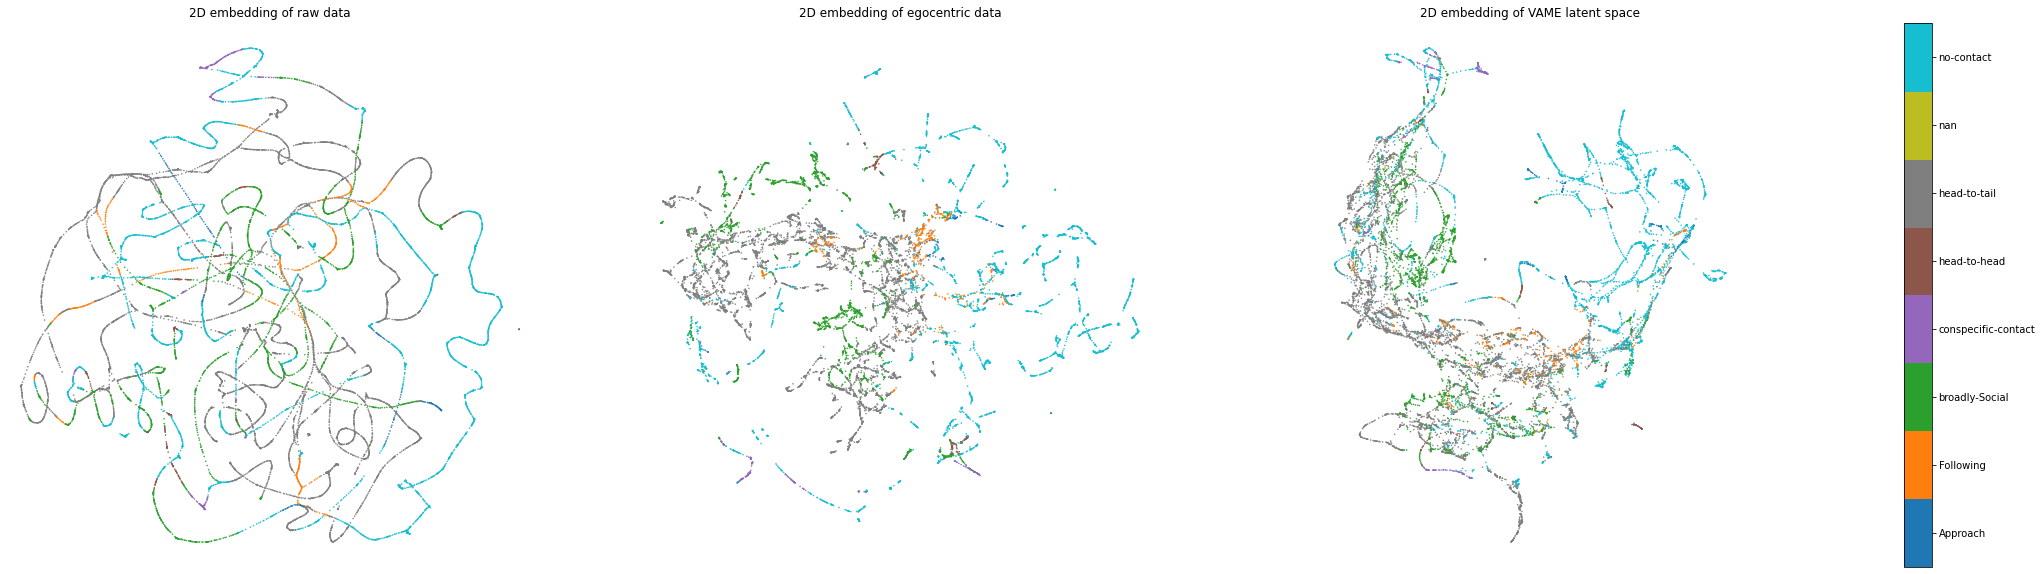

In [52]:
fig, axs = plt.subplots(1,3, figsize=(40,10))
for ax in axs: ax.axis('off')
scatter0 = axs[0].scatter(raw_umap_embed[:,0], raw_umap_embed[:,1],s=0.3, c=labels, cmap='tab10')
axs[0].set_title("2D embedding of raw data")
axs[0].set_aspect('equal', 'datalim')

scatter1 = axs[1].scatter(ego_umap_embed[:,0], ego_umap_embed[:,1],s=0.3, c=labels, cmap='tab10')
axs[1].set_title("2D embedding of egocentric data")
axs[1].set_aspect('equal', 'datalim')

scatter2 = axs[2].scatter(umap_embed[:, 0], umap_embed[:, 1], c=labels, s=0.3, cmap='tab10')
axs[2].set_aspect('equal', 'datalim')
axs[2].set_title("2D embedding of VAME latent space")
cb = plt.colorbar(scatter2,ax=axs.ravel().tolist(), boundaries=n.arange(n.max(labels)+2)-0.5)
cb.set_ticks(n.arange(n.max(labels)+1))
cb.ax.set_yticklabels(unique_labels);
# cb1 = plt.colorbar(scatter1,boundaries=n.arange(n.max(k_means_labels)+2)-0.5)
# cb1.set_ticks(n.arange(n.max(k_means_labels)+1))
plt.savefig('figs/umap-with-without-VAME.png', dpi=500)

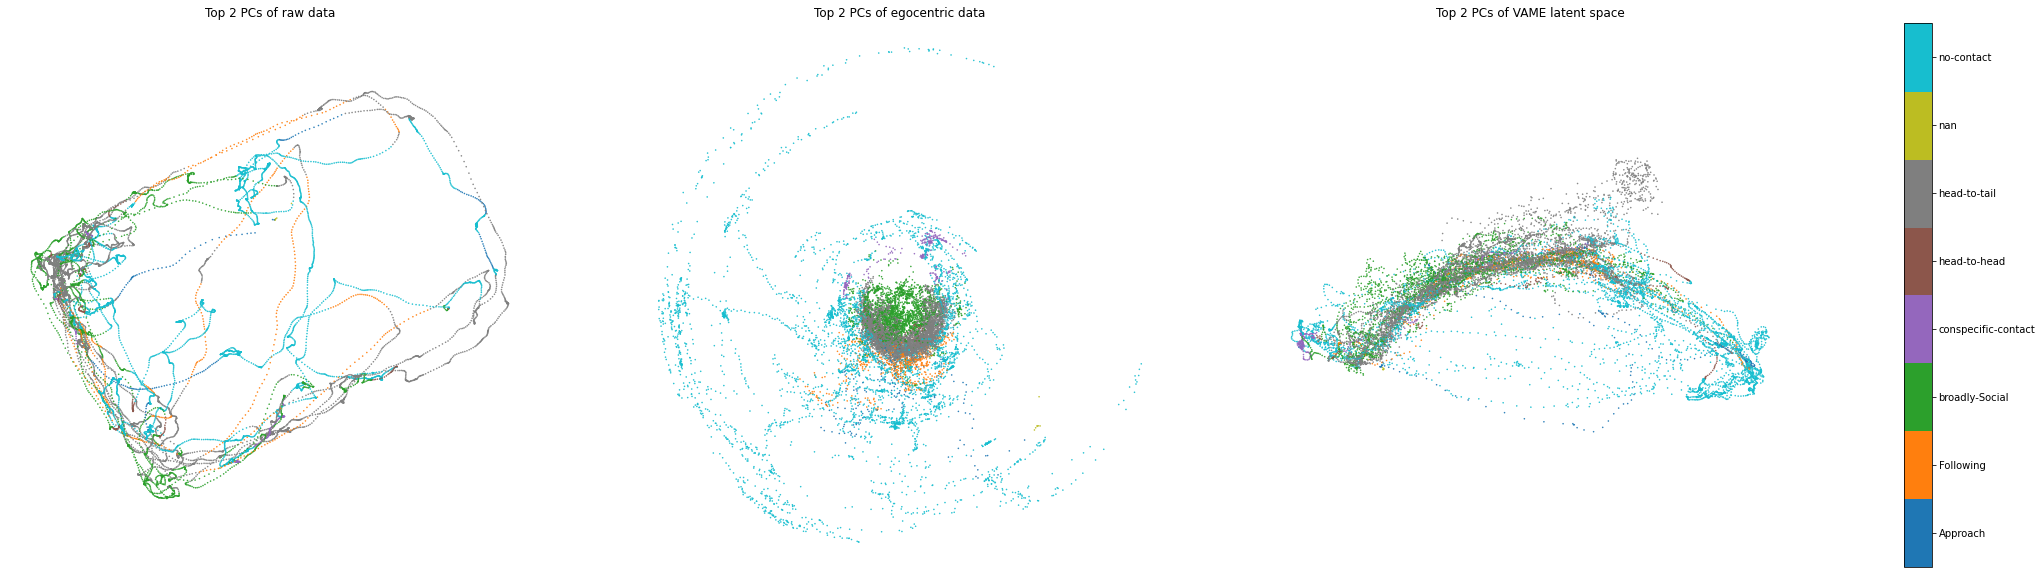

In [54]:
fig, axs = plt.subplots(1,3, figsize=(40,10))
for ax in axs: ax.axis('off')
scatter0 = axs[0].scatter(raw_pca_embed[:,0], raw_pca_embed[:,1],s=0.3, c=labels, cmap='tab10')
axs[0].set_title("Top 2 PCs of raw data")
axs[0].set_aspect('equal', 'datalim')

scatter1 = axs[1].scatter(ego_pca_embed[:,0], ego_pca_embed[:,1],s=0.3, c=labels, cmap='tab10')
axs[1].set_title("Top 2 PCs of egocentric data")
axs[1].set_aspect('equal', 'datalim')

scatter2 = axs[2].scatter(pca_embed[:, 0], pca_embed[:, 1], c=labels, s=0.3, cmap='tab10')
axs[2].set_aspect('equal', 'datalim')
axs[2].set_title("Top 2 PCs of VAME latent space")
cb = plt.colorbar(scatter2,ax=axs.ravel().tolist(), boundaries=n.arange(n.max(labels)+2)-0.5)
cb.set_ticks(n.arange(n.max(labels)+1))
cb.ax.set_yticklabels(unique_labels);
# cb1 = plt.colorbar(scatter1,boundaries=n.arange(n.max(k_means_labels)+2)-0.5)
# cb1.set_ticks(n.arange(n.max(k_means_labels)+1))
plt.savefig('figs/PCA-with-without-VAME.png', dpi=500)

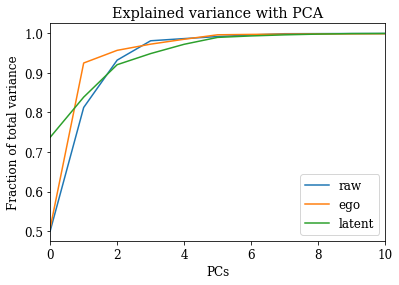

In [67]:
plt.plot([n.sum(raw_explained_var[0:i+1]) for i in range(len(raw_explained_var))],label='raw')
plt.plot([n.sum(ego_explained_var[0:i+1]) for i in range(len(ego_explained_var))],label='ego')
plt.plot([n.sum(explained_var[0:i+1]) for i in range(len(explained_var))],label='latent')
plt.xlim(0,10)
plt.title("Explained variance with PCA")
plt.xlabel('PCs')
plt.ylabel('Fraction of total variance')
plt.legend()

In [ ]:
clf = svm.SVC()
clf.fit(raw_vectors_ego, labels)

ego_score = clf.score(raw_vectors_ego, labels)
print(ego_score)

clf = svm.SVC()
clf.fit(raw_vectors, labels)

raw_score = clf.score(raw_vectors, labels)
print(raw_score)

clf = svm.SVC()
clf.fit(latent_vectors, labels)

latent_score = clf.score(latent_vectors, labels)
print(latent_score)

(0.5, 1.0)

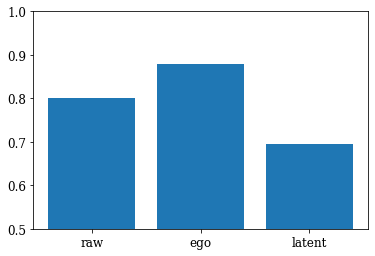

In [81]:
plt.bar([0,1,2], [raw_score, ego_score, latent_score])
plt.xticks([0,1,2],['raw','ego','latent'])
plt.ylim(0.5,1)

## Interpolation? 

In [85]:
t_start = 5000
t_burn_in = 1000
t_free = 100
t_end = 500

In [103]:
burn_in = latent_vectors[t_start:t_start+t_burn_in]
end = latent_vectors[t_start+t_burn_in:t_start+t_burn_in+t_end]

In [104]:
free_vecs = burn_in[-1] + ((n.arange(t_free)/t_free).reshape(t_free,1)@(end[0]-burn_in[-1]).reshape(1,-1))

In [108]:
feed = n.concatenate([burn_in, free_vecs, end],axis=0)

In [112]:
true_out = raw_vectors_ego[t_start:t_start+t_end+t_free]

In [114]:
model_path = os.path.join(path, 'model', 'best_model', 'VAME_both-rats.pkl')

In [116]:
model_path

'/mnt/d/SWC/EN/both-rats-Nov25-2020/model/best_model/VAME_both-rats.pkl'

In [131]:
import vame

In [122]:
config = os.path.join(path,'config.yaml')

In [125]:
config

'/mnt/d/SWC/EN/both-rats-Nov25-2020/config.yaml'

In [132]:
vame.rnn_model(config, model_name="VAME", pretrained_weights=True, pretrained_model="VAME")

Train RNN model!
CUDA is not working!


NotImplementedError: GPU Computing is required!

In [120]:
with open(model_path, 'rb') as f:
    model = pickle.load(f)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.